In [4]:
## Initialization cell ##

import requests
import oauth2
import json
import pickle 
import os

## Twitter Init ##
with open("twitter_auth.json", 'r') as f:
    auth_codes = json.load(f)
    
## Pickle file Init ##
def load_pickle(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    return data
    
def add_to_pickle_file(fname, new_data):
    # Given a pickle filename, append to it the new data (in our case, a list of dicts)
   
    # Check that file is not empty, otherwise initialize
    if os.path.getsize(fname) > 0:      
        with open(fname, 'rb') as f:
            unpickler = pickle.Unpickler(f);
            data = unpickler.load()
    else:
        data = []
    
    print("Old length of file: {:d}".format(len(data)))
    data = data + new_data
    print("New length of file: {:d}".format(len(data)))
    
    with open(fname, 'wb') as f:
        pickle.dump(data, f)


pickle_file = "ben_labels.pckl"
# pickle_file = "patrick_labels.pckl"

## Positive and negative lexicon import ##
def read_text(filename, comment=";"):
    """ Given a filename, read in every line that is not commented"""
    f = open(filename, 'r', encoding='ISO-8859-1')
    out_list = []
    
    for line in f:
        if line[0] != comment:
            out_list.append(line.strip('\n'))
    
    f.close()
    
    return out_list

pos_vocab = read_text("positive-words.txt")
neg_vocab = read_text("negative-words.txt")

## Lexicon of English import ##
def read_words(filename):
    out = []
    with open(filename, 'r') as f:
        for line in f:
            out.append(line.strip('\n'))
    return out

english_words = read_words("words_alpha.txt")


In [ ]:
## Fetch Tweets ##
def oauth_req(url, http_method="GET", post_body=b"", http_headers=None):
    consumer = oauth2.Consumer(key=auth_codes["key"], secret=auth_codes["secret"])
    token = oauth2.Token(key="", secret="")
    client = oauth2.Client(consumer, token)
    resp, content = client.request( url, method=http_method, body=post_body, headers=http_headers )
    return content

byteResponse = oauth_req('https://api.twitter.com/1.1/search/tweets.json?q=a&lang=en&count=100&tweet_mode=extended', "GET")
tweets = json.loads(byteResponse)

In [ ]:
## Label Tweets ##

# Usage: 
# 0) Make empty file called "patrick_labels.pckl" in working directory
# 1) Select correct pickle file
# 2) Label tweets as appropriate
# 3) When finished, type "done" into the emotion box to automatically have tweets uploaded to the pickle file. 

labeledTweets = []

print("Total number of tweets to analyze in this session: {:d}".format(len(tweets['statuses'])))

# p - positive, n - negative, i - informational, h - humor, a - advertisement, o - none of the above
for status in tweets['statuses']:
    text = status['full_text']
    # If this is a retweet, the full_text field gets cut off at 140 characters, 
    # so we have to get the whole text from the retweeted_status field
    if text[0:4] == 'RT @':
        text = status['retweeted_status']['full_text']
    print(text)
    emotion = input("What emotion is this? (type 'done' to save current progress to file) ")
    print("\n")
    if emotion.lower() == "done":
        break
    tweet = {"status": text, "userId": status['user']['id'], "emotion": emotion}
    labeledTweets.append(tweet)

add_to_pickle_file("patrick_labels.pckl", labeledTweets)
print("Added {:d} datapoints".format(len(labeledTweets)))

In [ ]:
## transfer txt file to pickle file ##
import ast

f = open("patrickClassified.txt",'r')
lines = f.readlines()
f.close()

dictString = ""
inStatus = False
tweets = []
for i, line in enumerate(lines):
    if "\'emotion\'" in line:
        if "[" in line:
            ind = line.index("[") + 1
            line = line[ind:]
        dictString = dictString + line
    elif "\'status\'" in line:
        inStatus = True
        dictString = dictString + line
    elif "\'userId\'" in line:
        inStatus = False
        if "," in line:
            ind = line.index(",")
            line = line[:ind]
        elif "]" in line:
            ind = line.index("]")
            line = line[:ind]
        dictString = dictString + line
        tweet = ast.literal_eval(dictString.lstrip())
        tweets.append(tweet)
        dictString = ""
    elif inStatus:
        dictString = dictString + line

#add_to_pickle_file("patrick_labels.pckl", tweets)
        

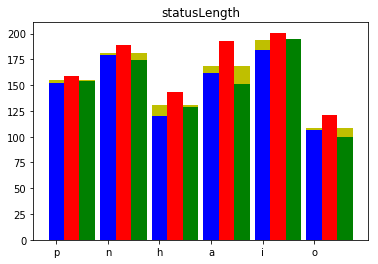

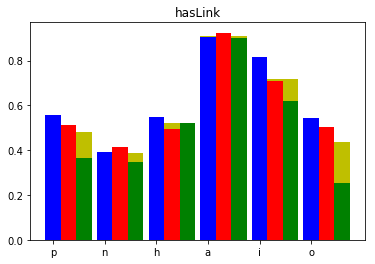

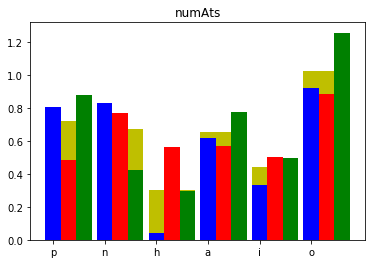

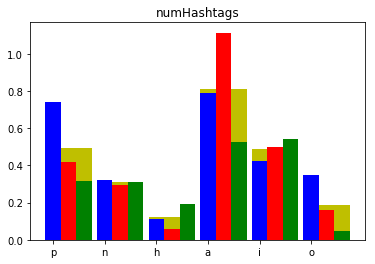

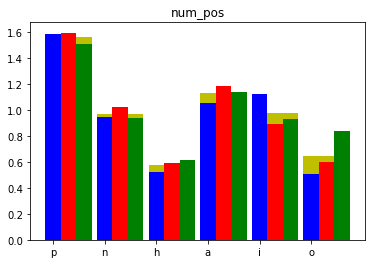

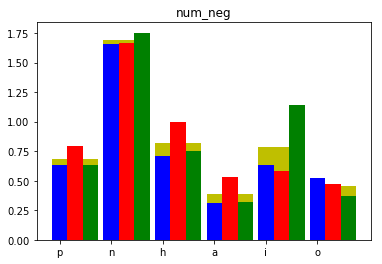

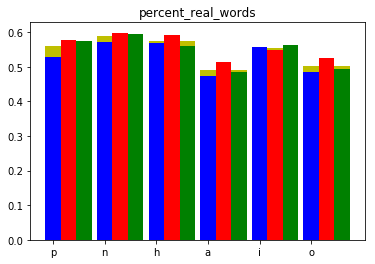

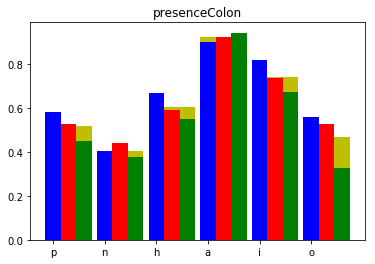

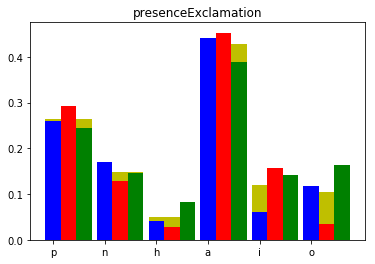

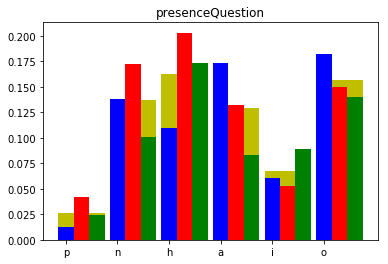

In [5]:
## Experimenting to see what features will work best ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Feature ideas: length of status, presence of url, number of @'s, number of #'s, presence/number of emojis, 
# number of numeric/special characters as opposed to alpha, wordnet to assess sentiment, number of alpha words that
# are not real dictionary words, 'not' analysis?

## Definitions ##
def num_pos(status, pos_words=pos_vocab):
    from nltk import word_tokenize
    
    p = 0
    
    for w in word_tokenize(status.lower()):
        if binarySearch(pos_words, w):
            p = p + 1 
            
    return p

def num_neg(status, neg_words=neg_vocab):
    from nltk import word_tokenize
    
    n = 0
    for w in word_tokenize(status.lower()):
        if binarySearch(neg_words, w):
            n = n + 1 
            
    return n

def count_emojis(status):
    import regex as re
    
    emoji_regex = r'[\uD83C-\uDBFF\uDC00-\uDFFF]'
    text_emoji_regex = r'[:;=][ -*]*?[\[\]\(\)DPpXx3/\\]' # Included some common regex expressions. '...*?...' 
    text_reverse_emoji_regex = r'[\[\]\(\)DPpxX/\\][ -*]*?[:;=]' # Included some common reverse regex expressions. 
    total_regex = r'(' + emoji_regex + r'|' + text_emoji_regex + r'|' + text_reverse_emoji_regex + r')'
    rexp = re.compile(total_regex)
    num_emojis = len(rexp.findall(status))
    
    return num_emojis

def percent_real_words(status, lexicon=english_words):
    from nltk import word_tokenize
    
    out = 0
    words = word_tokenize(status.lower()) 
    for w in words:
        if binarySearch(lexicon, w):
            out = out + 1
            
    out = out / len(words)
            
    return out

def binarySearch(lex, word):
    from bisect import bisect_left    
    pos = bisect_left(lex, word)
    return (pos < len(lex) and lex[pos] == word)

def statusLength(status):
    return len(status)

def hasLink(status):
    if "https://" in status:
        return 1
    else:
        return 0
    
def numAts(status):
    return status.count("@")

def numHashtags(status):
    return status.count("#")

def presenceColon(status):
    if ':' in status:
        return 1
    else:
        return 0

def presenceExclamation(status):
    if '!' in status:
        return 1
    else:
        return 0
    
def presenceQuestion(status):
    if '?' in status:
        return 1
    else:
        return 0


features = [statusLength, hasLink, numAts, numHashtags, num_pos, num_neg, percent_real_words,
            presenceColon, presenceExclamation, presenceQuestion]

#Define data
patrickData = load_pickle("patrick_labels.pckl")
benData = load_pickle("ben_labels.pckl")
patrickDatas = [patrickData[:400], patrickData[400:], benData]
numGroups = len(patrickDatas)

#Define categories
allCategories = ["p","n","h","a","i","o"]


## Extract feature information from data ##
featureDatas = []
for i in range(0, numGroups):
    allStatuses = {}
    for category in allCategories:
        allStatuses[category] = []
    for tweet in patrickDatas[i]:
        categories = tweet['emotion']
        for category in categories:
            allStatuses[category].append(tweet['status'])
    
    featureData = {}

    for category in allCategories:
        statuses = allStatuses[category]
        numStatuses = len(statuses)
        totals = {}
        avgs = {}
        #Initialize and calculate totals for each feature
        for feature in features:
            totals[feature] = 0
        for status in statuses:
            for feature in features:
                totals[feature] += feature(status)
        #Compute and storeaverages for each feature
        for feature in features:
            avgs[feature] = totals[feature]/numStatuses
        featureData[category] = avgs
        #for feature in features:
            #print(totals[feature]/numStatuses)
    featureDatas.append(featureData)

    
    
## Plots to show results ##
colors = ['b','r','g', 'c', 'm', 'k']
for feature in features:
    x_pos = np.arange(len(allCategories))
    w = 0.9 / numGroups
    ax = plt.subplot(111)
    
    #Total
    y = []
    for category in allCategories:
        totalAvg = 0
        for i in range(0, numGroups):
            totalAvg += featureDatas[i][category][feature]/numGroups
        y.append(totalAvg)
    ax.bar([pos + w*(numGroups - 1)/2 for pos in x_pos], y,width=0.9,color='y',align='center')
    
    #For each group
    for i in range(0, numGroups):
        y = []
        for category in allCategories:
            y.append(featureDatas[i][category][feature])
        ax.bar([pos + w*i for pos in x_pos], y,width=w,color=colors[i],align='center')

    plt.xticks(x_pos, allCategories)
    plt.title(feature.__name__)
    plt.show()

In [3]:
## Format data to pass to machine learning algorithms ##

# Convert from list of dictionaries to matrix
def data_format_XY(data, feature_list, categories=["p","n","h","a","i","o"]): 
    # Data is the list of dictionaries
    # Feature list is a list of the features we want to extract
    # Categories is the complete list of categories, mapped to integers 0-5
    
    # Change support to multilabel classification using sklearn's MultiLabelBinarizer
    
    import numpy as np
    
    cat_dict = {k:v for (k,v) in zip(categories, range(len(categories)))}
    
    statuses = [d['status'] for d in data for _ in d['emotion']]
    labels = [cat_dict[e] for d in data for e in d['emotion']]
    
    Y = np.array(labels)
    X = np.zeros((len(Y), len(feature_list)))
    
    for i, f in enumerate(feature_list):
        curr_feats = [f(s) for s in statuses]
        X[:, i] = np.array(curr_feats)
        
    return X, Y

# Scale features
def preprocess_features(X):
    X_out = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    return X_out
    
# Separate into Train and Test
def train_test_split(X_full, Y_full, frac_test=0.33):
    import numpy as np
    
    np.random.seed(0)
    idx = np.random.permutation(len(Y_full))
    split_ind = int(np.round((1 - frac_test) * len(Y_full)))
    
    X_train = X_full[idx[-split_ind:]]
    X_test = X_full[idx[:-split_ind]]
    Y_train = Y_full[idx[-split_ind:]]
    Y_test = Y_full[idx[:-split_ind]]
    
    return X_train, Y_train, X_test, Y_test


def data_format_multilabel(data, feature_list, categories=["p","n","h","a","i","o"]): 
    # Data is the list of dictionaries
    # Feature list is a list of the features we want to extract
    # Categories is the complete list of categories, mapped to integers 0-5
    
    # Change support to multilabel classification using sklearn's MultiLabelBinarizer
    
    import numpy as np
    
    cat_dict = {k:v for (k,v) in zip(categories, range(len(categories)))}
    Y = np.zeros((len(data), len(categories)))
    
    for i, d in enumerate(data):
        for e in d['emotion']:
            Y[i, cat_dict[e]] += 1
    
    statuses = [d['status'] for d in data]
    
    X = np.zeros((len(Y), len(feature_list)))
    
    for i, f in enumerate(feature_list):
        curr_feats = [f(s) for s in statuses]
        X[:, i] = np.array(curr_feats)
        
    return X, Y


In [6]:
## Evaluation functions ## 
def pct_correct(Y_est, Y_true):
    import numpy as np
    
    return np.sum(Y_est == Y_true)/len(Y_true)

In [13]:
## Setup experiments ##
# Define useful features
all_features = [statusLength, hasLink, numAts, numHashtags, num_pos, num_neg, percent_real_words,
            presenceColon, presenceExclamation]

# Process data
data1 = load_pickle("patrick_labels.pckl")
data2 = load_pickle("ben_labels.pckl")

# Change below if only want to analyze one
data = data1 + data2

X, Y = data_format_XY(data, all_features)
X = preprocess_features(X)
X_train, Y_train, X_test, Y_test = train_test_split(X, Y)

In [ ]:
# General flow of sklearn objects:
#   model = SklearnModel(<params>)
#   model.fit(X_train, Y_train)
#   model.predict(X_test)

In [ ]:
import scipy.io

scipy.io.savemat('tweetData.mat', {'data': X, 'labels': Y})

In [ ]:
## Single Label Classifiers ##
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

clf = classifiers[0]
clf.fit(X_train, Y_train)
est = clf.predict(X_test)

# Test estimator
from sklearn import metrics

pct_correct(est, Y_test)


In [26]:
## Multi Label Classifiers ##
all_features = [statusLength, hasLink, numAts, numHashtags, num_pos, num_neg, percent_real_words,
            presenceColon, presenceExclamation]

# Process data
data1 = load_pickle("patrick_labels.pckl")
data2 = load_pickle("ben_labels.pckl")

# Change below if only want to analyze one
data = data1 + data2

# Select features
features = all_features

X, Y = data_format_multilabel(data, all_features)
X = preprocess_features(X)
X_train, Y_train, X_test, Y_test = train_test_split(X, Y)

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=30, n_estimators=100)
est = clf.fit(X_train, Y_train).predict(X_test)